# Return Correlations
This notebook is for the next phase of our risk project, assessing the correlation of various stocks' _returns_ over different timeframes. In particular, we want to look at correlations of _weekly returns_ between _each pair_ of companies for _6-month periods._  
We'll probably have to re-collect the WRDS data, since we never saved the weekly returns anywhere. This could take a minute.

In [1]:
import pandas as pd
import numpy as np
import wrds
import pandas_market_calendars as mcal
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
conn = wrds.Connection(wrds_username='kaihvc')

Loading library list...
Done


## Data collection
The following cells re-collect daily return data from the WRDS database and calculate weekly returns from it. It takes about 50 minutes to make the database request and save the file, so it's better just to read the dataframe from disk at `wrds_results/weekly_rets.csv` after the first time.

In [2]:
# setup for wrds data
def get_days(start_dt, end_dt):
    nyse = mcal.get_calendar('NYSE')
    return [day.date() for day in nyse.valid_days(start_date=str(start_dt), 
                                                end_date=str(end_dt))]

def get_weeks(start_dt, end_dt):
    weeks = []

    # get trading days and divide into weeks, rolling over on the given rollover day
    current_week = []
    days = get_days(start_dt, end_dt)
    for i, day in enumerate(days):
        # append to current week
        current_week.append(day)

        #end of the week check
        if i+1<len(days):
            next_day = days[i+1]
            if next_day.weekday() < day.weekday(): #if the next day's weekday comes before the current, then the next_day is in a new week
                weeks.append(current_week)
                current_week = []
            elif (next_day-day).days > 4: #if the condition above didnt pass, check that >4 days didnt pass as well
                weeks.append(current_week)
                current_week = []

    # append final week, even if it wasn't a full week period
    if current_week: weeks.append(current_week)

    return weeks

def get_periods(weeks):
    periods = []
    start_date = weeks[0][0]
    end_date = None
    for i in range(len(weeks)-1):
        start = weeks[i][0] #this monday
        end = weeks[i][-1]  #this friday

        next_start = weeks[i+1][0] #next monday
        next_end = weeks[i+1][-1]  #next friday

        #if the current friday is in december, and the next weeks friday is in january, this is the end of one period
        #the very next week will be the very start of the period\
        if end.month == 12 and next_end.month == 1:
            end_date = end
            periods.append([start_date,end_date])
            start_date = next_start
        #if the last day is in june, and the next weeks last day is in july, this is the end of one period
        #the very next week will be the very start of the period
        if end.month == 6 and next_end.month == 7:
            end_date = end
            periods.append([start_date,end_date])
            start_date = next_start
    periods.append([start_date, weeks[i+1][-1]])
    for i in periods:
        i[1] += timedelta(days=3)
    return periods

def periodToStr(period):
    return period[0].strftime("%m/%d/%Y") + " - " + period[1].strftime("%m/%d/%Y")

# initialize company list
companies = conn.get_table(library='crsp', table='stocknames')

In [3]:
# WRDS database request & processing
# build SQL query using inflation-adjusted mcaps

# load inflation-adjusted market caps from file (equivalents of 2020 $10mil)
def get_cutoffs(filename):
    cutoffs = pd.read_csv(filename)[['observation_date', 'Cutoff Value']]
    cutoffs['year'] = pd.to_datetime(cutoffs['observation_date']).apply(lambda x: x.year)
    cutoffs = cutoffs.set_index('year').drop(columns='observation_date')
    return cutoffs

# build query, filtering using inflation-adjusted mcap values
def build_query(start_dt, end_dt, adjusted_mcaps):
    query = f"SELECT cusip, date, ret, prc, shrout FROM crsp.dsf WHERE date>='{str(start_dt)}' AND date<='{str(end_dt)}' AND ("
    for i, year in enumerate(adjusted_mcaps.loc[start_dt.year:].index):
        query += f"(EXTRACT(YEAR FROM date)={year} AND prc*shrout>={int(adjusted_mcaps.loc[year][0] / 1000)})"
        query += " OR " if i < len(adjusted_mcaps.loc[start_dt.year:].index) - 1 else ")"
    return query
        
# get daily returns
def get_returns(start_dt, end_dt, adjusted_mcaps, username='kaihvc'):
    conn = wrds.Connection(wrds_username=username)
    query = build_query(start_dt, end_dt, adjusted_mcaps)
    df = conn.raw_sql(query)
    return df

# TODO: test for accuracy
def pd_process_weekly(df, start_dt, end_dt):
    
    # get inflation cutoffs (GDPDEF method, courtesy of Dr. Ikenberry)
    # unused - atm we're filtering directly in the SQL request
#     cutoffs = get_cutoffs('inflation_adjustments.csv')
#     df = filter_for_inflation(df, cutoffs)[['ret']]
    
    # takes ~25-30 min (?) all told; most spent on the aggregation
    # group by cusip & weeks, then geometrically expand week groups to get weekly returns
    df['date'] = pd.to_datetime(df['date'])
    grouper = pd.Grouper(key='date', freq='W-MON')
    grouped = df.groupby(by=['cusip', grouper], observed=True)
    weekly_rets = grouped.agg({'ret': lambda x: (x + 1).product() - 1})
    
    return weekly_rets

# unused - atm we're filtering directly in the SQL request
# def filter_for_inflation(df, infl_cutoffs_by_year):
#     if 'date' in df.columns:
#         cutoffs = pd.to_datetime(df['date']).apply(lambda x: infl_cutoffs_by_year.loc[x.year])
#         keep_indices = (df['prc'] * df['shrout'] * 1000) >= [val[0] for val in cutoffs.values]
#         df = df[keep_indices]
#     elif 'date' in df.index.names:
#         cutoffs = pd.to_datetime(df.index.get_level_values('date')).apply(lambda x: infl_cutoffs_by_year.loc[x.year])
#         keep_indices = (df['prc'] * df['shrout']) >= [val[0] for val in cutoffs.values]
#         df = df[keep_indices] 
#     else:
#         print("Error: df doesn't contain 'date' in index or columns")
        
#     return df

### Load weekly returns
The cells below set the run parameters and load in the weekly returns, controlled by `requery` and `recalc`. If `requery == True`, we query the WRDS database for daily returns again. If `recalc == True`, we also recalculate the weekly returns, using the `daily_rets` dataframe in memory or reading it from disk.  
The process is split into multiple cells because I wanted to go out for drinks while the query ran, without coming back to a melted computer if something went wrong during the calculation. _Separation of concerns - all the cool programmers are doing it._

In [6]:
# parameters
# we'll use the 1950 inflation-adjusted equivalent of a 2020 $10mil mcap minimum, and do more fine-grained filtering later
start_dt = date(1950, 1, 1)
end_dt = date(2021, 1, 1)
# min_cap_1950 = 1133 # $1,133,256 in 1950 = $10mil in 2020; unused atm

In [5]:
# query returns
requery = False
if requery:
    exec_start = datetime.now()
    print("Querying WRDS for daily returns...")
    daily_rets = get_returns(start_dt, end_dt, get_cutoffs('inflation_adjustments.csv'))
    print(f"Query complete in {str(datetime.now() - exec_start)}, writing to disk...")
    stage_start = datetime.now()
    daily_rets.to_csv('wrds_results/daily_rets_adjusted_prcshrout.csv')
    print(f"Disk write complete in {str(datetime.now() - stage_start)}")
    print(f"Download complete in {str(datetime.now() - exec_start)}")

In [3]:
# calculate returns
recalc = False
if recalc:
    if 'daily_rets' not in globals():
        print("Loading daily returns from file...")
        daily_rets = pd.read_csv('wrds_results/daily_rets_adjusted.csv', index_col=0)
    exec_start = datetime.now()
    weekly_rets = pd_process_weekly(daily_rets, start_dt, end_dt)
    print(f"Processing complete in {str(datetime.now() - exec_start)}, writing to disk...")
    weekly_rets.to_csv('wrds_results/weekly_rets_adjusted.csv')
    print(f'Weekly returns downloaded in {str(datetime.now() - exec_start)}')
else:
    weekly_rets = pd.read_csv('wrds_results/weekly_rets_adjusted.csv', index_col=[0, 1])
    weekly_rets.index = weekly_rets.index.set_levels([weekly_rets.index.levels[0], pd.to_datetime(weekly_rets.index.levels[1])])
    print('Weekly returns loaded')

Weekly returns loaded


## Get market cap at end of january for verification

In [61]:
companies = conn.get_table(library='crsp', table='stocknames').set_index('cusip')[['ticker', 'comnam', 
                                                                               'namedt', 'nameenddt']]

In [ ]:
def get_januaries():
    jans = []
    for year in range(1950, 2022):
        if date(year, 1, 31).weekday() < 5:
            jans.append(date(year, 1, 31))
        elif date(year, 1, 30).weekday() < 5:
            jans.append(date(year, 1, 30))
        else:
            jans.append(date(year, 1, 29))
    return jans

In [11]:
df_together = []
for jan_date in get_januaries():
    temp_df = daily_rets.loc[daily_rets['date'] == jan_date][['cusip', 'prc', 'shrout']]
    df_together.append(temp_df)
    
df_together = pd.concat(df_together, keys=range(1950, 2022))
df_together.to_csv('wrds_results/end_of_jan_data.csv')

In [33]:
df_together = df_together.set_index([df_together.index.get_level_values(0), 'cusip'])

In [119]:
# names = companies.loc[df_together.index.get_level_values(1)]
# names
import numpy as np

names = []
for i, row in df_together.iterrows():
    select_df = companies.loc[i[1]]
    if isinstance(select_df, pd.DataFrame):
        select_array = np.logical_and([i[0] >= x.year for x in select_df['namedt']], 
                                      [i[0] <= x.year for x in select_df['nameenddt']])
        selection = select_df[select_array].iloc[0]
        names.append(selection['comnam'])
#         tickers.append(selection['ticker'])
    else:
        names.append(select_df['comnam'])
#         tickers.append(select_df['ticker'])

In [126]:
df_together

prc    shrout          mcap  \
     cusip                                         
1950 39106410  12.500000    1500.0  1.875000e+07   
     39111810  42.750000    3093.0  1.322258e+08   
     39199190  19.750000    1800.0  3.555000e+07   
     40067610   7.875000     410.0  3.228750e+06   
     40237010  14.375000     917.0  1.318188e+07   
...                  ...       ...           ...   
2020 79409310   1.380000   21130.0  2.915940e+07   
     65490220   3.880000  663103.0  2.572840e+09   
     09248T10  14.430000    7308.0  1.054544e+08   
     25179M10  21.719999  384100.0  8.342652e+09   
     68243Q10  15.190000   35754.0  5.431032e+08   

                                          names  
     cusip                                       
1950 39106410     GREAT NORTHERN IRON ORE PPTYS  
     39111810         GREAT NORTHERN RAILWAY CO  
     39199190              GREAT WESTN SUGAR CO  
     40067610               GUANTANAMO SUGAR CO  
     40237010          GULF MOBILE & OHIO RR CO  
...                                         ...  
2020 79409310             SALEM MEDIA GROUP INC  
     65490220                        NOKIA CORP  
     09248T10  BLACKROCK STRATEGIC MUNICIPAL TR  
     25179M10             DEVON ENERGY CORP NEW  
     68243Q10             1 800 FLOWERS COM INC  

[286453 rows x 4 columns]

## Calculate 6-month correlations
The following cells calculate return correlations over ~6-month periods from the weekly returns. Note that this generates a correlation matrix _for each period_, so it might take a _while_.

We apply the same filter for each period, requiring it to have at least 20/26 weeks from each period to be included in the correlation matrix. _Only stocks which pass the filter are found in the correlation matrix,_ meaning that it's possible for correlation matrices from different periods to have different sizes (though all will be square).

In [8]:
# get specific dataframe indices for each period cause multiindex slicing is incorrigible
def get_per_idxs(df, periods):
    per_dict = {}
    per_idx = 0
    per = periods[per_idx]
    idx_list = []
    for i, idx in enumerate(df.sort_index(level='date').index):
        if idx[1].date() < per[1]:
            idx_list.append(idx)
        else:
            per_dict[per_idx] = idx_list
            idx_list = []
            per_idx += 1
            if per_idx >= len(periods):
                break
            per = periods[per_idx]
            
    return per_dict

# get correlation matrices for each period
# accepts weekly returns df, start/end dates, and (inclusive) starting period
def get_corrs(df, start_dt, end_dt, start_from=0):
    
    current_iteration = start_from
    periods = get_periods(get_weeks(start_dt, end_dt))
    idx_dict = get_per_idxs(df, periods)
    num_pers = len(periods)

    for i, per in enumerate(periods[start_from:]):
        
        # timing
        iter_start = datetime.now()
        
        # filter for cusips w/ at least 20
#         this should be idx_dict[i] right?
        counts = weekly_rets.loc[idx_dict[i]].groupby('cusip').count()
        cusips = counts[counts >= 20].dropna().index # TODO: Figure out whether this filter is messing things up
        
        # select data for period, filter out missing data, and unstack to get df of shape (dates, cusips)
        filtered_df = weekly_rets.loc[idx_dict[i]].loc[cusips].unstack(level='cusip')
        filtered_df.columns = filtered_df.columns.droplevel(0)
        
        # calculate correlation matrix & print 
        corr = filtered_df.corr()
        corr.to_csv(f'wrds_results/corr_dump/{str(per[0])}_corr.csv')
        print(f'Period {str(per[0])} complete ({i + start_from + 1}/{num_pers}) in {str(datetime.now() - iter_start)}')
        clear_output(wait=True)

In [9]:
exec_start = datetime.now()
get_corrs(weekly_rets, start_dt, end_dt)
print(f'Period correlations complete in {str(datetime.now() - exec_start)}')

Period correlations complete in 1:15:12.391305


In [53]:
idx_dict = get_per_idxs(weekly_rets, periods)

In [73]:
num_stocks = [len(np.unique([elt[0] for elt in idx_dict[i]])) for i in idx_dict]

In [55]:
# idxs = get_per_idxs(weekly_rets, get_periods(get_weeks(start_dt, end_dt)))
# num_stocks = [len(weekly_rets.loc[idx_dict[idxs[i]]].index.get_level_values(0).unique()) for i in idxs]
num_stocks = [len(weekly_rets.loc[idx_dict[i]].index.get_level_values(0).unique()) for i in idx_dict]

In [74]:
# num_stocks

[999,
 1013,
 1025,
 1033,
 1036,
 1044,
 1052,
 1047,
 1044,
 1052,
 1064,
 1066,
 1064,
 1066,
 1079,
 1088,
 1083,
 1078,
 1083,
 1094,
 1112,
 1130,
 1139,
 1160,
 1167,
 2042,
 2065,
 2083,
 2111,
 2126,
 2162,
 2184,
 2198,
 2203,
 2216,
 2264,
 2267,
 2277,
 2317,
 2359,
 2404,
 2454,
 2502,
 2555,
 2639,
 2725,
 2739,
 2726,
 2683,
 2622,
 2588,
 2571,
 2585,
 2541,
 2540,
 2527,
 2503,
 2501,
 2451,
 2418,
 2400,
 2391,
 2387,
 2381,
 2349,
 2410,
 2616,
 3101,
 3430,
 3558,
 4312,
 4513,
 4733,
 5078,
 5369,
 5551,
 5448,
 5449,
 5312,
 5253,
 5139,
 5029,
 5011,
 5223,
 6292,
 6677,
 7010,
 7600,
 7952,
 8172,
 8180,
 8469,
 8804,
 9127,
 9163,
 9330,
 9254,
 9062,
 8747,
 8725,
 8650,
 8487,
 7984,
 7596,
 7261,
 7002,
 6813,
 6823,
 6829,
 6894,
 6875,
 6955,
 6949,
 7015,
 7146,
 7174,
 7005,
 6856,
 6541,
 6576,
 6590,
 6638,
 6630,
 6627,
 6609,
 6576,
 6586,
 6705,
 6873,
 7035,
 7068,
 7148,
 7029,
 7039,
 7018,
 7155,
 7300,
 7352,
 7395,
 7420,
 7501,
 7826]

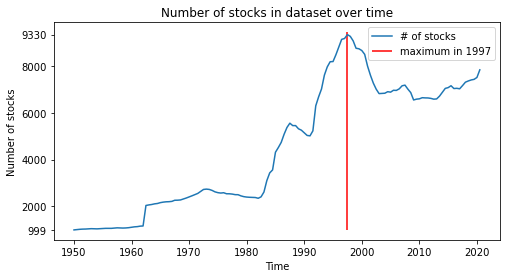

In [100]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Number of stocks in dataset over time")
ax.set_xlabel("Time")
ax.set_ylabel("Number of stocks")

max_per = np.argmax(num_stocks)
max_stocks = np.max(num_stocks)
min_stocks = np.min(num_stocks)
ax.vlines(max_per, 1000, max_stocks + 100, color='red', label=f'maximum in {int(1950 + max_per / 2)}')

ax.set_yticks([min_stocks, 2000, 4000, 6000, 8000, max_stocks])
ax.set_yticklabels([min_stocks, 2000, 4000, 6000, 8000, max_stocks])

xticks = [0, 20, 40, 60, 80, 100, 120, 140]
labels = [int(1950 + xtick / 2) for xtick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(labels)

ax.plot(num_stocks, label='# of stocks')
ax.legend()
plt.show()

## Concatenating correlations
The following few cells concatenate the calculated correlations into a single multiindexed dataframe. This makes it much easier to manipulate the data for various flexible purposes.

In [18]:
def concatenate_corrs(periods):
    corrs_master = []
    for period in periods:
        idx = period[0]
        
        corr = pd.read_csv(f'wrds_results/corr_dump/{idx}_corr.csv', index_col=0)
        corrs_master.append(corr)
        
        print(f'Period {period[0]} complete')
        
        clear_output(wait=True)
    
    print('Concatenating...')
    return pd.concat(corrs_master, keys=[per[0] for per in periods])

In [ ]:
start_dt = date(1950, 1, 1)
end_dt = date(2021, 1, 1)

In [ ]:
exec_start = datetime.now()
periods = get_periods(get_weeks(start_dt, end_dt))
all_corrs = concatenate_corrs(periods)
print(f'Done in {str(datetime.now() - exec_start)}')

In [ ]:
all_corrs.to_csv('wrds_results/all_corrs.csv')

TODO
- Transition matrix/heatmap as table (round to ~3 decimals or so), so we have a way to look at the numbers instead of just colors

## Markov modeling
Our transition matrix generation function will require some updates, since we're doing it for state matrices instead of state vectors. However, this shouldn't be too difficult; our main considerations will be:
- Removing the upper-triangular & diagonal portion of the matrix, so we only consider our _actual_ data, and only consider it _once_
- Matching cusips between periods - we'll naturally have a few dropouts between periods, and the concatenation process means the matrix won't be completely square, so this will simply take some conscientiousness.

In [10]:
def stderr_tril_qcut(df, q, cusips):
    
    # get particular cusips
    data = df.loc[cusips][cusips].values
    lower_tri = data[np.tril_indices(len(data), k=-1)]
    
    # get stderr of data
    stderrs = (lower_tri - np.mean(lower_tri)) / np.std(lower_tri)
    
    # build bins
    # NOTE: we'll ALWAYS need the <-2 and >2 bins, since otherwise the things aren't comparable
    intervals = [pd.Interval(elt, elt + 0.5) for elt in np.arange(-2, 2, 0.5)]
    intervals = [pd.Interval(-np.inf, -2)] + intervals + [pd.Interval(2, np.inf)]    
    intervals = pd.IntervalIndex(intervals)
    
    discretized = pd.cut(stderrs, intervals, include_lowest=True)
    labels = range(1, len(discretized.categories) + 1)
    return pd.Series(discretized.rename_categories(labels)).astype(int)

def tril_qcut(df, q, cusips):
    
    # get particular cusips
    data = df.loc[cusips][cusips].values
    lower_tri = data[np.tril_indices(len(data), k=-1)]
    
    # NOTE: we're using straight qcut here, so high correlations will be in high quantiles
    return pd.qcut(lower_tri, q, labels=range(1, q + 1))

In [24]:
def get_transition_matrix(periods, n_quantiles, stderr=False):
    transition_matrices = []
    periods = periods[:-2]
    n_decades = len(periods) // 20
    for i in range(n_decades):
        transition_matrices.append(np.zeros((n_quantiles + 1, n_quantiles + 1)))

    for per_idx in range(len(periods) - 1):
        
        # read in correlation matrices
        print(f'Adding period {periods[per_idx][0]}...')
        clear_output(wait=True)
        iter_start = datetime.now()
        current_corr = pd.read_csv(f'wrds_results/corr_dump/{periods[per_idx][0]}_corr.csv', index_col=0)
        next_corr = pd.read_csv(f'wrds_results/corr_dump/{periods[per_idx + 1][0]}_corr.csv', index_col=0)
        
        # fix weird string/float error
        current_corr.index = current_corr.index.astype('string')
        next_corr.index = next_corr.index.astype('string')
        
        # determine overlap & get data
        cusips = current_corr.index[current_corr.index.isin(next_corr.index)]
        try:
            if stderr:
                current_q = stderr_tril_qcut(current_corr, n_quantiles, cusips)
                next_q = stderr_tril_qcut(next_corr, n_quantiles, cusips)
            else:
                current_q = tril_qcut(current_corr, n_quantiles, cusips)
                next_q = tril_qcut(next_corr, n_quantiles, cusips)
        except Exception as err:
            print(f"Error in period {periods[per_idx][0]}")
            print(err)
#             with open('error_log.txt', 'w') as file:
#                 file.write(f"Fucked up in period {periods[per_idx][0]}:")
#                 file.write(err)
        assert len(current_q) == len(next_q), 'Unequal lengths - something is fucked'
        
        # build transition matrix
        for j in range(len(current_q)):
            transition_matrices[per_idx // 20][current_q[j]][next_q[j]] += 1
            
        print(f'Period {periods[per_idx][0]} complete in {str(datetime.now() - iter_start)}')
            
    # normalize transition matrix
    for decade in range(n_decades):
        for i in range(n_quantiles + 1):
            mat_sum = np.sum(transition_matrices[decade][i])
            if mat_sum > 0:
                transition_matrices[decade][i] /= mat_sum
            
    return transition_matrices

In [25]:
# deciles
recalc = True
if recalc:
    start_dt = date(1950, 1, 1)
    end_dt = date(2021, 1, 1)
    periods = get_periods(get_weeks(start_dt, end_dt))
    exec_start = datetime.now()
    transition_matrices = get_transition_matrix(periods, 10)
    for i, mat in enumerate(transition_matrices):
        np.save(f'wrds_results/correlation_transition_deciles_dec{i}', mat)
    print(f'Transition matrix complete in {str(datetime.now() - exec_start)}')
else:
    transition_mat = np.load('wrds_results/correlation_transition_deciles.npy')
    sns.heatmap(transition_mat)

C:\Users\Kai\AppData\Local\Temp\ipykernel_4332\233648148.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  next_corr = pd.read_csv(f'wrds_results/corr_dump/{periods[per_idx + 1][0]}_corr.csv', index_col=0)


Period 2018-12-31 complete in 0:02:15.096022
Transition matrix complete in 2:29:58.692916


In [26]:
# stderr
recalc = True
if recalc:
    start_dt = date(1950, 1, 1)
    end_dt = date(2021, 1, 1)
    periods = get_periods(get_weeks(start_dt, end_dt))
    exec_start = datetime.now()
    transition_matrices = get_transition_matrix(periods, 10, stderr=True)
    for i, mat in enumerate(transition_matrices):
        np.save(f'wrds_results/correlation_transition_stderr_dec{i}', mat)
    print(f'Transition matrix complete in {str(datetime.now() - exec_start)}')
else:
    transition_mat = np.load('wrds_results/correlation_transition_stderr.npy')
    sns.heatmap(transition_mat)

C:\Users\Kai\AppData\Local\Temp\ipykernel_4332\233648148.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  next_corr = pd.read_csv(f'wrds_results/corr_dump/{periods[per_idx + 1][0]}_corr.csv', index_col=0)


Period 2018-12-31 complete in 0:02:40.162935
Transition matrix complete in 2:56:23.094326


# np.sum(transition_mat[1])

In [12]:
pd.DataFrame(transition_mat).round(3).to_csv('wrds_results/transition_mat_stderr_tabular.csv')

## Period-varying correlations
In the following few cells, we'll investigate how a given stock's correlation with subsequent stocks varies over time, for each stock in the period.

### Investigation 1: Consecutive periods
In this investigation, we'll look at how stock correlations vary between _consecutive_ periods. We expect this to be relatively high, but it's possible we'll find surprises.

In [ ]:
per_idxs = [per[0] for per in periods]

In [ ]:
# compute consecutive correlations
# there's a better way to do this using groupby but I can't think what it is
exec_start = datetime.now()
per_dict = dict()
for i, per in enumerate(per_idxs[:-1]):
    corr_dict = dict()
    for cusip in cusips:
        corr_dict[cusip] = all_corrs[cusip][per].corr(all_corrs[cusip][per_idxs[i + 1]])
    per_dict[per] = corr_dict

df_consecutive = pd.DataFrame(per_dict)
print(f'Complete in {str(datetime.now() - exec_start)}')

In [ ]:
df_consecutive.iloc[333].dropna().plot()
plt.show()

### Investigation 2: Increasing distance
In this investigation, we'll look at how stock correlations vary between an initial period and each subsequent period. We can take, for example, a stock's correlation to each other one in the first half of 1960, and correlate it to the second half of 1960. Then we'd correlate the first halves of 1960 and 1961, then the first half of 1960 with the second half of 1961, and so on. (Recall we did this with correlations of standard deviations earlier.) 

In [ ]:
# compute correlations over increasing distance
exec_start = datetime.now()
decade_dict = dict()
num_decades = len(per_idxs) // 7
decades = [1950 + i * 10 for i in range(num_decades)]
for decade in decades:
    per_dict = dict()
    for per in per_idxs[1:]:
        corr_dict = dict()
        for cusip in cusips:
            corr_dict[cusip] = all_corrs[cusip][per_idxs[0]].corr(all_corrs[cusip][per])
        per_dict[per] = corr_dict

    df_consecutive = pd.DataFrame(per_dict)
    decade_dict[decade] = df_consecutive
print(f'Complete in {str(datetime.now() - exec_start)}')

In [ ]:
decade_dict.keys()